In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import Image
from IPython import get_ipython
ipython = get_ipython()

# Autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Ignore exceptions
import expectexception

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Visualizations
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

# Suppress rpy2 runtime warnings
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

# Load ipywidgets module
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [110]:
%%R

# Visualization
library(ggplot2)
library(ggalt)
library(ggExtra)
library(ggcorrplot)
library(ggthemes)
library(ggdendro)
library(GGally)
library(ggrepel)
theme_set(theme_light())

# Tidyverse library
library(scales)
library(dplyr)
library(tidyr)
library(forcats)
library(readr)
library(purrr)

# String manipulations
library(tools)
library(lubridate)

# Machine Learning Related
library(car)
library(caTools)
library(pROC)

# Misc
library(psych)
library(mice)

In [4]:
bank = pd.read_csv('../../Homework Data/Homework 6 Data/data_banknote_authentication.csv', header=None)

In [5]:
X = bank.drop(4, axis=1)
y = bank[4]

In [6]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

def bayes_opt():
    # Set up space dictionary with specified hyperparameters
    space = {'alpha' : hp.loguniform('alpha', -8, 3)}

    # Set up objective function
    def objective(params):
        params = {'alpha' : params['alpha']}
        
        lin_svc = SGDClassifier(**params, penalty='l1', # Specify L1-penalty
                                max_iter=30000,
                                learning_rate='optimal', early_stopping=True) # Hinge Loss is used by default
        
        best_score = cross_val_score(lin_svc, X_train, y_train, cv=5, 
                                     scoring='accuracy', n_jobs=-1).mean() # 5-fold cv
        
        loss = 1 - best_score
        return loss

    # Run the algorithm
    best = fmin(fn=objective,
                space=space, 
                max_evals=100, # Control how many evaluations to take
                rstate=np.random.RandomState(408),
                algo=tpe.suggest,
                show_progressbar=False)

    return best


def svc():
    best_param = bayes_opt() # Get best parameters from Bayesian Optimization
    lin_svc = SGDClassifier(**best_param, penalty='l1', 
                            max_iter=30000,
                            learning_rate='optimal', early_stopping=True)
    lin_svc.fit(X_train, y_train)
    return (1 - lin_svc.score(X_test, y_test)) # Return test error

In [10]:
# Specify minimum sample in train data

end_indices = list(range(40, 901, 20))
test_size = 472/1372

Note that 40 instead of 10 samples are selected within the initial training set to prevent from cross-validation error. **It makes no sense to perform 5-fold stratified CV with only 10 samples.**

# Passive Learning

In [12]:
from sklearn.model_selection import train_test_split

big_error_array = []

# Perform 25 Monte-Carlo Simulations
for num in range(1, 26):
    
    # Perform train-test split randomly in a stratified manner
    rand_int = np.random.randint(1e9)
    X_train_whole, X_test, y_train_whole, y_test = train_test_split(X, y, test_size=test_size, 
                                                                    stratify=y, random_state=rand_int)
    error_array = []
    
    # Get test error for different training sizes
    for x in end_indices:
        X_train = X_train_whole.iloc[:x]
        y_train = y_train_whole.iloc[:x]
        error = svc()
        error_array.append(error)
        
    big_error_array.append(error_array)
    
    # Keep track of iteration status
    if num%5 == 0:
        print('{} iterations done!'.format(num))

5 iterations done!
10 iterations done!
15 iterations done!
20 iterations done!
25 iterations done!


Only 25 Simulations are performed for the sake of time.

In [15]:
big_error_array = np.array(big_error_array)

In [16]:
passive_error = np.mean(big_error_array, axis=0)

# Active Learning

In [91]:
def svc2():
    best_param = bayes_opt() # Get best parameters from Bayesian Optimization
    lin_svc = SGDClassifier(**best_param, penalty='l1', 
                            max_iter=30000,
                            learning_rate='optimal', early_stopping=True)
    lin_svc.fit(X_train, y_train)
    # Return test error and distance to hyperplane
    return (1 - lin_svc.score(X_test, y_test), lin_svc.decision_function(X_remaining))

In [92]:
big_error_array2 = []

# Perform 25 Monte-Carlo Simulations
for num in range(1, 26):
    
    # Perform train-test split randomly in a stratified manner
    rand_int = np.random.randint(1e9)
    X_train_whole, X_test, y_train_whole, y_test = train_test_split(X, y, test_size=test_size, 
                                                                    stratify=y, random_state=rand_int)
    
    X_train, X_remaining, y_train, y_remaining = train_test_split(X_train_whole, y_train_whole,
                                                                  test_size=860/900, stratify=y_train_whole,
                                                                  random_state=408)
    # Convert the data to numpy arrays
    X_train, X_remaining, y_train, y_remaining = X_train.values, X_remaining.values,\
                                                 y_train.values, y_remaining.values
    
    error_array = []
    
    # Get test error for different training size
    remaining_size = 860
    
    while remaining_size > 0:
        # retrieve test error and distance to hyperplane
        error, hyperplane_dist = svc2()
        error_array.append(error)
        
        # Get the closest 20 points to the hyperplanes and add to train data accordingly
        s = list(enumerate(np.abs(hyperplane_dist)))
        closest_20_pts = sorted(s, key = lambda x: x[1])[:20]
        desired_indices = [x[0] for x in closest_20_pts]
        new_X = X_remaining[desired_indices]
        new_y = y_remaining[desired_indices]
        X_train = np.append(X_train, new_X, axis=0)
        y_train = np.append(y_train, new_y)
        
        # Remove the added points accordingly
        X_remaining = np.delete(X_remaining, desired_indices, axis=0)
        y_remaining = np.delete(y_remaining, desired_indices)
        
        remaining_size -= 20
    
    big_error_array2.append(error_array)
    
    # Keep track of iteration status
    if num%5 == 0:
        print('{} iterations done!'.format(num))

5 iterations done!
10 iterations done!
15 iterations done!
20 iterations done!
25 iterations done!


In [93]:
big_error_array2 = np.array(big_error_array2)

In [94]:
active_error = np.mean(big_error_array2, axis=0)

# Learning Curve

In [125]:
learning_curve = pd.DataFrame(np.column_stack([end_indices[2:], active_error, passive_error[2:]]),
                              columns=['sample_size', 'active', 'passive'])

In [126]:
%%R -i learning_curve

error = ggplot(learning_curve, aes(x=sample_size)) +
    geom_line(aes(y=active, col='red'), alpha=0.8) +
    geom_line(aes(y=passive, col='blue'), alpha=0.8) +
    scale_x_continuous(breaks=seq(100,900,100)) +
    labs(title='Active Learning VS Passive Learning',
         x='Training Data Size',
         y='Error Rate') +
    scale_colour_manual(values=c('blue'='blue','red'='red'), 
                        labels=c('Passive','Active'),
                        name=NULL)

png(file='./HW6_image/learning_curve.png', width=750, height=500)
error

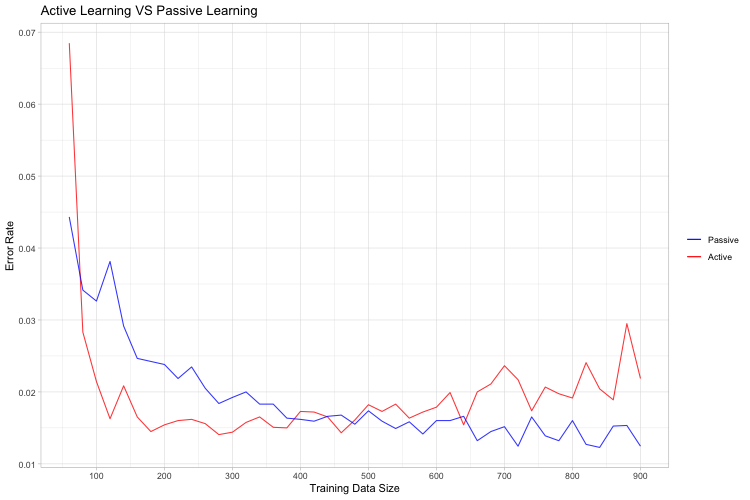

In [127]:
Image('./HW6_image/learning_curve.png')

The following observations can be seen from the graph:
- **As training data size increases, the test error decreases on average**.
- **Active learning performs better** because highly influential points, the closest points to the hyperplanes (i.e. the likely support vectors) are iteratively selected as training data. Whereas random points are chosen for passive learning.
- We can see a **big gap in performance between active learning and passive learning** when training data is relatively small.
- The gap reduces as training data increases. We can **expect the same performance** as the training data get asymptotically large. Here, passive learning actually outperforms active learning towards the end.
